# Section 3: Real-time Token Updates
- **`SUBSCRIBE_OHLCV`** - Real-time OHLCV candlestick updates
- **`SUBSCRIBE_TXS`** - Real-time Transaction updates
- **`SUBSCRIBE_TOKEN_STATS`** - Real-time token statistics updates

Let's build real-time monitoring systems for blockchain data!

## Setup and Imports

**Important**: This section requires a **Business API Key** from Birdeye Data Services for WebSocket features.

### Getting Your Business API Key

The real-time WebSocket features require access to premium endpoints that are only available with a Business package. Your workshop host will provide you with a Business API key.

**Add the Business API key to your .env file:**
```
BDS_API_KEY=your_business_api_key_here
```

If you don't have a Business API key, you can:
1. Contact your workshop host for a temporary key
2. Sign up for a Business plan at [Birdeye Data Services](https://bds.birdeye.so)
3. Continue with the demo to see how the features work

In [16]:
# Import required libraries
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display, HTML, Markdown, clear_output
import ipywidgets as widgets
from datetime import datetime, timedelta
import json
import time
import threading
import warnings
warnings.filterwarnings('ignore')

# Force reload of utils module to ensure latest version
import utils
import importlib
importlib.reload(utils)

# Import our custom utilities
from utils import (
    BirdeyeDataServices, 
    BirdeyeDataServicesWebSocket,
    create_portfolio_chart,
    create_portfolio_pie_chart,
    create_candlestick_chart,
    format_currency,
    format_transaction_data,
    check_api_key
)

print("All modules imported successfully for real-time updates!")

# Check Business API key and initialize client
if check_api_key('business'):
    # Initialize Birdeye Data Services client with Business API key
    birdeye = BirdeyeDataServices(api_key_type='business')
    print("Setup complete! Ready for real-time blockchain data monitoring.")
else:
    print("Please configure BDS_API_KEY in your .env file")
    print("Contact your workshop host for a Business API key")

All modules imported successfully for real-time updates!
✅ BDS_API_KEY found!
Setup complete! Ready for real-time blockchain data monitoring.


### Troubleshooting Note

**If you encounter import errors:**
1. **Restart the kernel**: Go to `Kernel` → `Restart` in the menu
2. **Re-run the import cell above**
3. **Clear browser cache** if the issue persists

The functions exist in `utils.py` and the reload code above should resolve any caching issues.

## Step 1: Interactive OHLCV Charts

Let's start with interactive OHLCV charts for detailed price analysis:

Creating OHLCV chart for SOL...

SOL OHLCV Chart:


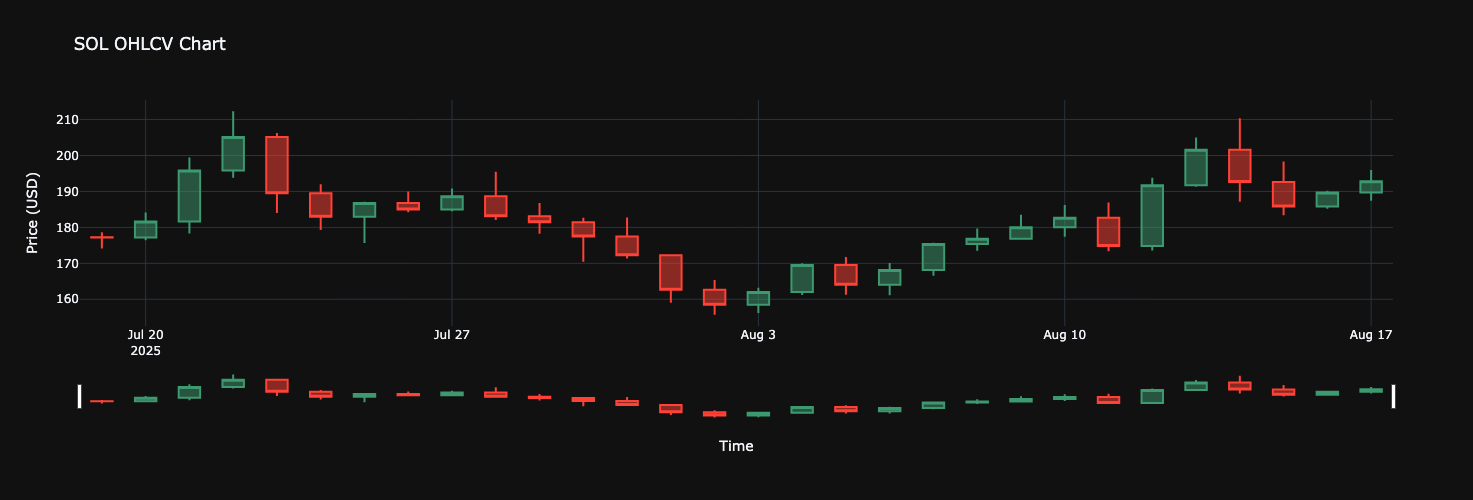


Chart Features:
   Green candles: Price increased (Close > Open)
   Red candles: Price decreased (Close < Open)
   Volume bars: Trading activity
   Interactive: Zoom, pan, and hover for details

Interactive Controls:


In [17]:
# Step 1: Interactive OHLCV Charts
def create_interactive_ohlcv_chart(token_address=None, token_symbol="Token"):
    if not token_address:
        token_address = "So11111111111111111111111111111111111111112"  # Default to SOL
        token_symbol = "SOL"
    
    print(f"Creating OHLCV chart for {token_symbol}...")
    
    ohlcv_data = birdeye.get_ohlcv_data(token_address, type_="1D")
    
    if ohlcv_data:
        candlestick_chart = create_candlestick_chart(ohlcv_data, token_symbol)
        
        if candlestick_chart:
            print(f"\n{token_symbol} OHLCV Chart:")
            candlestick_chart.show()
            
            print("\nChart Features:")
            print("   Green candles: Price increased (Close > Open)")
            print("   Red candles: Price decreased (Close < Open)")
            print("   Volume bars: Trading activity")
            print("   Interactive: Zoom, pan, and hover for details")
        else:
            print("Could not create chart")
    else:
        print("Could not fetch OHLCV data")

# Interactive controls for Step 1
step1_checkbox = widgets.Checkbox(
    value=False,
    description='Use custom token address',
    style={'description_width': 'initial'}
)

step1_token_input = widgets.Text(
    value='',
    placeholder='Enter token address',
    description='Token:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px')
)

step1_symbol_input = widgets.Text(
    value='',
    placeholder='Enter token symbol (e.g., USDC)',
    description='Symbol:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='200px')
)

step1_button = widgets.Button(
    description='Create OHLCV Chart',
    button_style='success',
    tooltip='Create candlestick chart'
)

step1_output = widgets.Output()

def on_step1_button_click(b):
    with step1_output:
        clear_output(wait=True)
        if step1_checkbox.value and step1_token_input.value.strip():
            symbol = step1_symbol_input.value.strip() or "Token"
            create_interactive_ohlcv_chart(step1_token_input.value.strip(), symbol)
        else:
            create_interactive_ohlcv_chart()

step1_button.on_click(on_step1_button_click)

# Initial execution
create_interactive_ohlcv_chart()

# Display interactive controls
print("\n" + "="*60)
print("Interactive Controls:")
display(widgets.VBox([
    step1_checkbox,
    widgets.HBox([step1_token_input, step1_symbol_input]),
    step1_button,
    step1_output
]))

## Step 2: Real-time token chart Updates

Let's implement real-time token chart updates using WebSocket connections:

In [ ]:
# Professional TradingView Chart Generator
import subprocess
import webbrowser
import os

# Create output widget for chart operations
chart_output = widgets.Output()

# Button to generate HTML chart
generate_chart_button = widgets.Button(
    description='📊 Generate Chart HTML',
    button_style='primary',
    tooltip='Generate standalone HTML chart file',
    layout=widgets.Layout(width='250px', height='50px')
)

# Button to view HTML chart
view_chart_button = widgets.Button(
    description='🌐 View Chart in Browser',
    button_style='success',
    tooltip='Open the generated HTML chart in browser',
    layout=widgets.Layout(width='250px', height='50px')
)

def generate_chart_html(b):
    with chart_output:
        clear_output(wait=True)
        print("📊 Generating TradingView Chart HTML...")
        print("="*50)
        
        # Check if the generator script exists
        if not os.path.exists('generate-chart-html.js'):
            print("❌ generate-chart-html.js not found!")
            print("Please make sure the Node.js files are in the current directory.")
            return
        
        try:
            # Run the HTML generator
            result = subprocess.run(['node', 'generate-chart-html.js'], 
                                  capture_output=True, text=True, timeout=30)
            
            if result.returncode == 0:
                print("✅ HTML chart generated successfully!")
                print("📄 File: bds-realtime-chart.html")
                print("\n🎯 Ready to view in browser!")
            else:
                print(f"❌ Generation failed: {result.stderr}")
                
        except subprocess.TimeoutExpired:
            print("❌ Generation timed out")
        except FileNotFoundError:
            print("❌ Node.js not found. Please install Node.js first.")
        except Exception as e:
            print(f"❌ Error: {e}")

def view_chart_in_browser(b):
    with chart_output:
        print("\n🌐 Opening chart in browser...")
        
        # Check if HTML file exists
        html_file = 'bds-realtime-chart.html'
        if not os.path.exists(html_file):
            print("❌ Chart HTML file not found!")
            print("Please generate the chart first by clicking 'Generate Chart HTML'")
            return
        
        try:
            # Get absolute path
            html_path = os.path.abspath(html_file)
            
            # Open in browser
            webbrowser.open(f'file://{html_path}')
            print("✅ Chart opened in browser!")
            print("\n📋 Usage Instructions:")
            print("   1. Click 'Load Chart' to fetch historical OHLCV data")
            print("   2. Click 'Connect WebSocket' for real-time updates")
            print("   3. Enter different token addresses to monitor other tokens")
            print("   4. Select different timeframes for various chart intervals")
            
        except Exception as e:
            print(f"❌ Error opening browser: {e}")
            print(f"Please manually open: {os.path.abspath(html_file)}")

# Connect button functions
generate_chart_button.on_click(generate_chart_html)
view_chart_button.on_click(view_chart_in_browser)

print("Generate standalone HTML charts with real-time OHLCV updates!")
display(widgets.HBox([generate_chart_button, view_chart_button]))
display(chart_output)


🚀 Professional TradingView Chart Generator:
Generate standalone HTML charts with real-time OHLCV updates!


Output()

## Congratulations!

You've successfully built a comprehensive real-time token monitoring system! Here's what you've accomplished:

### What You've Built:
- **Interactive OHLCV Charts**: Professional candlestick charts with custom token support
- **Real-time OHLCV, token stats and transactionMonitoring**: Live candlestick chart for 1 or multiple tokens

### Challenge Ideas:
- Add real-time alerts and notifications
- Implement custom trading signals
- Create automated monitoring dashboards
- Build multi-token comparison tools
- Add historical data correlation analysis
- Implement risk management monitoring

### Workshop Complete!

Great work! You're now ready to build the next generation of real-time blockchain applications!

### Additional Resources:
- [Birdeye API Documentation](https://docs.birdeye.so/reference)
- [Birdeye WebSocket Documentation](https://docs.birdeye.so/docs/websocket)